# `analysis`

In [ ]:
#| default_exp analysis

In [ ]:
#| export
import numpy as np
import math

In [ ]:
#| hide
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from nbdev import show_doc
from andi_datasets.models_phenom import models_phenom

# Angle calculation

In [ ]:
#| export 
def get_angle(a:tuple, # 2d position point A
              b:tuple, # 2d position point B
              c:tuple # 2d position point C       
             ) -> tuple:  # angle between segments AB and BC points
                
    ''' Calculates the angle between the segments generate by three points '''
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ang + 360 if ang < 0 else ang

def dataset_angles(trajs:list, # set of trajectories from which to calculate angles
                  ) -> list: # list of angles between displacements
    '''Given a set of trajectories, calculate all angles between displacements'''
    angles = []
    for traj in trajs:
        for a, b, c in zip(traj[:, :-2].transpose(), traj[:, 1:-1].transpose(), traj[:, 2:].transpose()):
            angles.append(get_angle(a, b, c))
    return angles

# MSD based analysis 

In [ ]:
#| export
class msd_analysis():
    def __init__(self):
        ''' Contains mean squared displacement (MSD) based methods to analyze trajectories.  '''
        

    def tamsd(self, 
              trajs:np.ndarray, 
              t_lags:np.ndarray,
              dim = 1
             ):
        '''
        Calculates the time average mean squared displacement (TA-MSD) of a trajectory at various time lags,
        
        Parameters
        ----------
        trajs : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : list | np.array
            Time lags used for the TA-MSD
        
        dim : int
            Dimension of the trajectories (currently only 1 and 2 supported)
        
        Returns       
        -------
        np.array
            TA-MSD of each trayectory / t_lag
            
        '''
        tamsd = np.zeros((len(t_lags), trajs.shape[0]), dtype= float)
        
        for idx, tlag in enumerate(t_lags):                  
            tamsd[idx, :] = ((trajs[:, tlag:, :]-trajs[:, :-tlag, :])**2).sum(-1).mean(1)
                                   
            
        return tamsd    

    def get_diff_coeff(self, 
                       trajs:np.ndarray, 
                       t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
        if len(trajs.shape) == 1:
            trajs = trajs[np.newaxis, :, np.newaxis]
        
        if not t_lags:
            N_t_lags = max(4, int(trajs.shape[1]*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(trajs, t_lags)
        
        return np.polyfit(t_lags, tasmd, deg = 1)[0, :]/2/trajs.shape[-1]

    def get_exponent(self, 
                     trajs:np.ndarray, 
                     t_lags:list = None):
        '''
        Calculates the diffusion coefficient of a trajectory by means of the linear
        fitting of the TA-MSD.
        
        Parameters
        ----------
        traj : np.array
            Set of trajectories of dimenions NxTxD (N: number of trajectories, T: lenght, D: dimension)
        
        t_lags : bool | list
            Time lags used for the TA-MSD.
        
        Returns       
        -------
        np.array
            Diffusion coefficient of the given trajectory.          
        
        '''
        
        # To account for previous versions of this function, we correct if given a single 1D trajectory
        if len(trajs.shape) == 1:
            trajs = trajs[np.newaxis, :, np.newaxis]
        
        if not t_lags:
            N_t_lags = max(4, int(trajs.shape[1]*0.1))
            t_lags = np.arange(1, N_t_lags)

        tasmd = self.tamsd(trajs, t_lags)
        
        return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]


    def get_optimal_tlags(self, 
                          x : float, # Reduced square localization error                          
                          T : int, # Lenght of the trajectory
                         ) -> tuple: # Optimal number of t_lags for fitting the intercept a and slope b of the tMSD
        '''
        Given the length of a trajectory and the reduced square localization error (see Eq. (4) in PRE E 85, 061916 (2012),
        returns a tuple with the optimal number of time lags for the fitting the intercept a and slope b of the tMSD.
        '''
        return self._p_min_a(x, T), self._p_min_b(x, T)

    @staticmethod
    def _fa(x): return 2 + 1.6 * x**0.51
    @staticmethod
    def _La(T): return 3 + (4.5 * T**0.4 - 8.5)**1.2
    @staticmethod
    def _fb(x): return 2 + 1.35 * x**0.6
    @staticmethod
    def _Lb(T): return 0.8 + 0.564 * T

    @staticmethod
    def _get_reduced_loc_error(sigma, D, deltaT, R):
        return sigma**2/(D*deltaT)-2*R
    
    def _p_min_a(self,
                 x : float, # Reduced square localization error
                 T : int # Lenght of the trajectory
                ) -> int: # Result of Eq. B3 from PRE E 85, 061916 (2012)
        fa_x = self._fa(x)
        La_N = self._La(T)
        E_fa_La = fa_x * La_N / (fa_x**3 + La_N**3)**(1/3)
        return int(np.round(E_fa_La))
    
    
    
    def _p_min_b(self,
                 x : float, # Reduced square localization error
                 T : int # Lenght of the trajectory
                ) -> int: # Result of Eq. B4 from PRE E 85, 061916 (2012)
        fb_x = self._fb(x)
        Lb_N = self._Lb(T)
        E_fb_Lb = fb_x * Lb_N / (fb_x**3 + Lb_N**3)**(1/3)
        return int(np.round(min(Lb_N, E_fb_Lb)))
    
    

In [ ]:
show_doc(msd_analysis.tamsd)

In [ ]:
show_doc(msd_analysis.get_diff_coeff)

Here we show an example for the calculation of the diffusion coefficient of a 2D Brownian motion trajectory. We create trajectories from displacements of variance $\sigma =1$, which results in a diffusion coefficient $D=0.5$.

<matplotlib.legend.Legend>

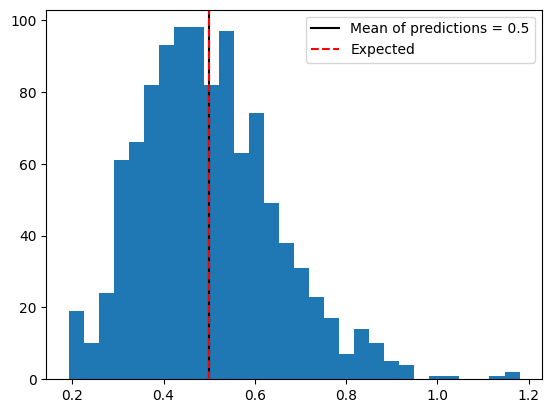

In [ ]:
pos = np.cumsum(np.random.randn(1070, 100, 2), axis = 1)
D = msd_analysis().get_diff_coeff(pos)

plt.hist(D, bins = 30);
plt.axvline(np.mean(D), c = 'k', label = f'Mean of predictions = {np.round(np.mean(D), 2)}')                                                                  
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

In [ ]:
show_doc(msd_analysis.get_exponent)

To showcase this function, we generate fractional brownian motion trajectories with $\alpha = 0.5$ and calculate their exponent:

(1001, 100, 2)


<matplotlib.legend.Legend>

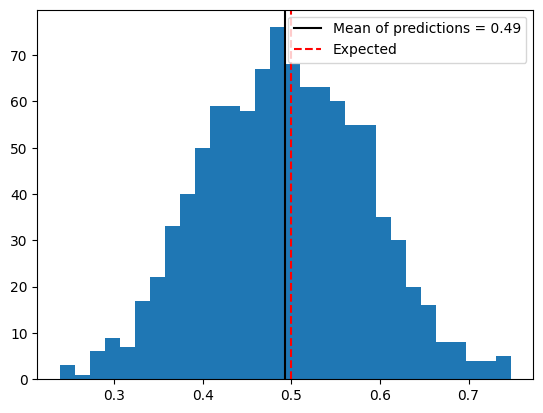

In [ ]:
trajs, _ = models_phenom().single_state(N = 1001, T = 100, alphas = 0.5, dim = 2)
alpha = msd_analysis().get_exponent(trajs.transpose(1,0,2))

plt.hist(alpha, bins = 30);
plt.axvline(np.mean(alpha), c = 'k', label = f'Mean of predictions = {np.round(np.mean(alpha), 2)}')
plt.axvline(0.5, c = 'r', ls = '--', label = 'Expected')
plt.legend()

# Velocity Autocorrelation Function (VACF)

In [ ]:
#| export
def vacf(trajs, 
         delta_t:int | list | np.ndarray  = 1, 
         taus:bool | list | np.ndarray = None):
    '''
    Calculates the velocity autocorrelation function for 
    the given set of trajectories.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    delta_t : int | list | array
     If not None, the vacf is calculated in the demanded time lags. 
        
    taus : bool |  list | array
     Time windows at wich the vacf is calculated. 
    
    Returns
    -------
    np.array
        VACF of the given trajectories and the given time windows.        
    '''
    if isinstance(delta_t, int): delta_t = [delta_t]
    
    if taus is None: taus = np.arange(1, trajs.shape[1]).astype(int)
        
    V = np.zeros((len(delta_t), len(taus)))
    for idx_d, delta in enumerate(delta_t):
        # Calculate the velocity
        velocity = trajs[: ,delta:] - trajs[:,:-delta]
        velocity /= delta_t   
    
    
        for idx_t, tau in enumerate(taus):
            if tau == 0:
                V[idx_d, idx_t] = (velocity**2).mean()
            else:
                V[idx_d, idx_t] = (velocity[:, :-tau]*velocity[:, tau:]).mean()
        V[idx_d, :] /= V[idx_d, 0]
        
    return V

We show here an example of the VACF for FBM trajectories at various time lages, showing that they all coincide (as expected for this diffusion model).

Text(0.5, 0, '$\\tau / \\delta$')

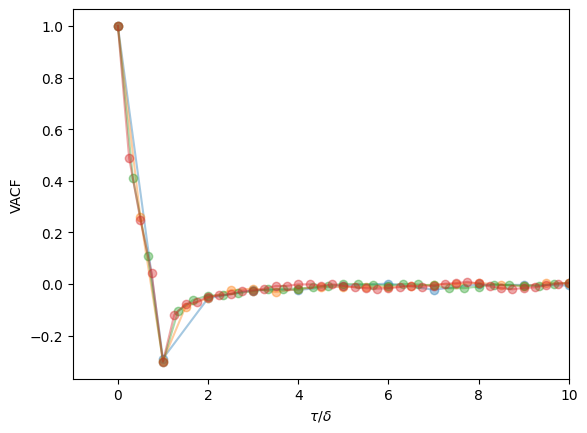

In [ ]:
deltats = np.arange(1, 5).tolist()
taus = np.arange(0, 100)
trajs, _ = models_phenom().single_state(N = 200, T = 200, alphas = 0.5)
trajs = trajs.transpose(1, 0, 2)[:,:,0]

for deltat in deltats:  
    v = vacf(trajs, deltat, taus)        
    plt.plot(taus/deltat, v.flatten(), 'o-', alpha = 0.4)    
plt.xlim(-1, 10)
plt.ylabel('VACF'); plt.xlabel(r'$\tau / \delta$')

# Convex hull analysis

In [ ]:
#| export
from scipy.spatial import ConvexHull

def CH_changepoints(trajs, 
                    tau:int = 10, 
                    metric:{'volume', 'area'} = 'volume'):
    ''' 
    Computes the changes points a multistate trajectory based on the Convex Hull approach proposed in PRE 96 (022144), 2017.
    
    Parameters
    ----------
    trajs : np.array
     NxT matrix containing N trajectories of length T.
        
    tau : int
     Time window over which the CH is calculated.
        
    metric : {'volume', 'area'} 
     Calculate change points w.r.t. area or volume of CH.
    
    Returns
    -------
    list
        Change points of the given trajectory.
    '''
    
    CPs = []
    for traj in trajs:
        traj = np.array(traj)

        Sd = np.zeros(traj.shape[0]-2*tau)
        for k in range(traj.shape[0]-2*tau):
            if metric == 'volume':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
            elif metric == 'area':
                Sd[k] = ConvexHull(traj[k:(k+2*tau)]).area

        below_mean = Sd < Sd.mean()
        cp_traj = np.argwhere(below_mean[1:] != below_mean[:-1])+1
        CPs.append(cp_traj+tau)

    return CPs

We showcase the use of the convex hull in a Brownian motion trajectory with two distinct diffusion coefficients, one 10 times the other:

Text(0, 0.5, '$S_d(n)$')

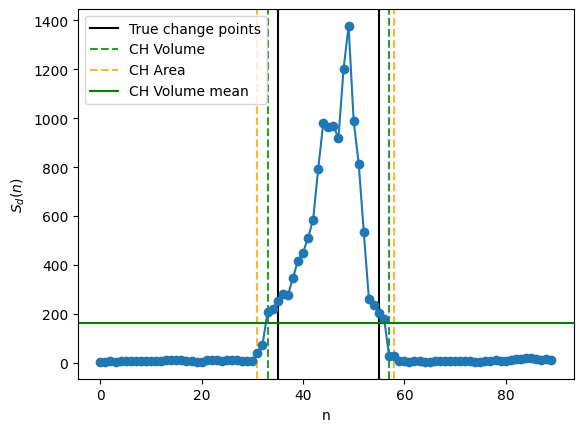

In [ ]:
# Generate trajectories and plot change points
T = 100; on = 40; off = 60; tau = 5
traj = np.random.randn(T, 2)
traj[on:off, :] = traj[on:off, :]*10
traj = traj.cumsum(0)
plt.axvline(on-tau, c = 'k')
plt.axvline(off-tau, c = 'k', label = 'True change points')

# Calculate variable Sd 
Sd = np.zeros(traj.shape[0]-2*tau)
for k in range(traj.shape[0]-2*tau):       
    Sd[k] = ConvexHull(traj[k:(k+2*tau)], ).volume  

# Compute change points both with volume and area
CPs = CH_changepoints([traj], tau = tau)[0].flatten()-tau
CPs_a = CH_changepoints([traj], tau = tau, metric = 'area')[0].flatten()-tau


# Plot everything
label_cp = 'CH Volume'
for cp in CPs:
    plt.axvline(cp, c = 'g', alpha = 0.8, ls = '--', label = label_cp)
    label_cp = ''
label_cp = 'CH Area'    
for cp in CPs_a:
    plt.axvline(cp, alpha = 0.8, ls = '--', c = 'orange', label = label_cp)
    label_cp = ''
    
plt.plot(Sd, '-o')
plt.axhline(Sd.mean(), label = 'CH Volume mean', c = 'g',)
plt.legend()
plt.xlabel('n'); plt.ylabel(r'$S_d(n)$')

# Cramér-Rao lower bound
> Expressions of the CRLB for the estimation of the diffusion coefficient for trajectories without noise, for dimension 1 and 2, at different trajectory lengths

In [ ]:
#| export
def CRLB_D(T:int, # Length of the trajectory
           dim:int = 1 # Dimension of the trajectoy
          ) ->float: # Cramér-Rao bound 
    '''
    Returns the Cramer-Rao lower bound S(D)/D for Brownian motion without noise, namely

    S(D) / D = sqrt(2 / (d·T) )
    '''
    return np.sqrt(2 / (dim*T))

Here we show how for Brownian motion trajectories, the MSD with is *nearly* optimal and follows the same scaling as the CRLB (i.e. $S(D)/D = \sqrt(6/T)$.

In [ ]:
#eval: false
Ts = np.logspace(1, 3,20).astype(int) # Trajectory lengths
Ds = np.arange(0.5, 2.1, 0.5) # We will test on different diffusion coefficients

# Saving the standard deviations
std_ds = np.zeros((len(Ds), len(Ts)))

for idxD, D in enumerate(tqdm(Ds)):
    
    # Generate the BM trajectories with given parameters
    trajs = (np.sqrt(2*D)*np.random.randn(int(1e4), Ts[-1], 1)).cumsum(1) 

    for idxL, T in enumerate(tqdm(Ts)):
        
        std_ds[idxD, idxL] = np.array(msd_analysis().get_diff_coeff(trajs = trajs[:, :T], t_lags = [1,2])).std()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

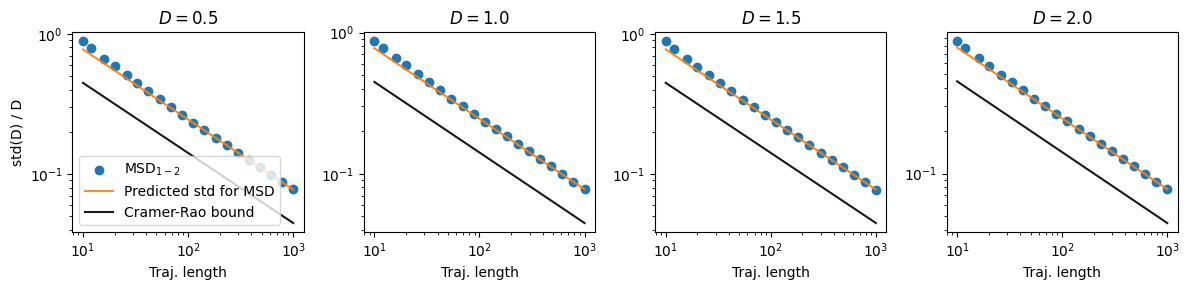

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (4*3,3), tight_layout = True)

for idx, (ax, std_d, D) in enumerate(zip(axs.flatten(), std_ds, Ds)):
    ax.scatter(Ts, std_d/D, label = r'MSD$_{1-2}$')
    ax.loglog(Ts, np.sqrt(6/Ts), label = 'Predicted std for MSD', alpha = 0.9, c = 'C1')
    ax.loglog(Ts, CRLB_D(Ts), label = 'Cramer-Rao bound', alpha = 0.9, c = 'k')
    ax.set_title(fr'$D = {D}$')
axs[0].legend()
plt.setp(axs[0], ylabel = 'std(D) / D')
plt.setp(axs, xlabel = 'Traj. length');

## Bounds for $\alpha$ and $K_{alpha}$ in FBM

In [ ]:
#| export
def generate_covariance_matrix(alpha, K_alpha, N, delta_t=1.0):
    """Generate the covariance matrix for FBM using vectorized operations."""
    indices = np.arange(N)
    diff = np.abs(indices[:, None] - indices)  # Create matrix of |i-j|
    
    term1 = np.abs(diff + 1)**alpha
    term2 = np.abs(diff - 1)**alpha
    term3 = np.abs(diff)**alpha

    covariance_matrix = K_alpha * delta_t**alpha * (term1 + term2 - 2 * term3)
    
    # Correct diagonal elements manually (as term1 and term2 would add 0 at diagonal)
    np.fill_diagonal(covariance_matrix, K_alpha * delta_t**alpha * 2)
    
    return covariance_matrix

def derivative_covariance_matrix_alpha(alpha, K_alpha, N, delta_t=1.0):
    """Calculate the derivative of the covariance matrix with respect to alpha using vectorized operations."""
    indices = np.arange(N)
    diff = np.abs(indices[:, None] - indices).astype(float)  # Create matrix of |i-j|  

    # Calculate the log terms, avoiding log(0) by setting these terms to zero
    log_term1 = np.log(np.abs(diff + 1), where=(diff + 1) > 0, out=np.zeros_like(diff))
    log_term2 = np.log(np.abs(diff - 1), where=(diff - 1) > 0, out=np.zeros_like(diff))
    log_term3 = np.log(np.abs(diff), where=diff > 0, out=np.zeros_like(diff))

    term1 = log_term1 * np.abs(diff + 1)**alpha
    term2 = log_term2 * np.abs(diff - 1)**alpha
    term3 = log_term3 * np.abs(diff)**alpha

    derivative_matrix = K_alpha * delta_t**alpha * (term1 + term2 - 2 * term3)
    
    return derivative_matrix

def derivative_covariance_matrix_K_alpha(alpha, K_alpha, N, delta_t=1.0):
    """Calculate the derivative of the covariance matrix with respect to K_alpha."""
    # The derivative of the covariance matrix Sigma with respect to K_alpha is Sigma / K_alpha,
    # we just compute Sigma for K_alpha = 1
    derivative_matrix = generate_covariance_matrix(alpha, 1.0, N, delta_t)
    return derivative_matrix
    

In [ ]:
#| export
def fisher_information_alpha(alpha, N, delta_t=1.0):
    """Calculate the Fisher Information component I_alpha,alpha."""

    # Note that the K_alpha terms will cancel when performing the dot product, hence we just 
    # set it to a placeholder value:
    K_alpha = 1
    
    Sigma = generate_covariance_matrix(alpha, K_alpha, N, delta_t)
    Sigma_inv = np.linalg.inv(Sigma)
    derivative_Sigma_alpha = derivative_covariance_matrix_alpha(alpha, K_alpha, N, delta_t)
    
    term = np.dot(Sigma_inv, derivative_Sigma_alpha)
    I_alpha_alpha = 0.5 * np.trace(np.dot(term, term))
    
    return I_alpha_alpha


def fisher_information_K_alpha(K_alpha, N, delta_t=1.0):
    """Calculate the Fisher Information component I_K_alpha,K_alpha.
    
    In this case, it can be analytically calculate as N/(2*K_alpha**2)    
    """    
    return N/(2*K_alpha**2) 

def fisher_information_cross(alpha, K_alpha, N, delta_t=1.0):
    """Calculate the Fisher Information cross term I_alpha,K_alpha."""
    Sigma = generate_covariance_matrix(alpha, K_alpha, N, delta_t)
    Sigma_inv = np.linalg.inv(Sigma)
    derivative_Sigma_alpha = derivative_covariance_matrix_alpha(alpha, K_alpha, N, delta_t)
    derivative_Sigma_K_alpha = derivative_covariance_matrix_K_alpha(alpha, K_alpha, N, delta_t)
    
    term_alpha = np.dot(Sigma_inv, derivative_Sigma_alpha)
    term_K_alpha = np.dot(Sigma_inv, derivative_Sigma_K_alpha)
    I_cross = 0.5 * np.trace(np.dot(term_alpha, term_K_alpha))
    
    return I_cross

def fisher_information_matrix(alpha, K_alpha, N, delta_t=1.0):
    """Calculate the full Fisher Information Matrix and its inverse."""
    I_alpha_alpha = fisher_information_alpha(alpha, N, delta_t)
    I_K_alpha_K_alpha = fisher_information_K_alpha(K_alpha, N, delta_t)
    I_cross = fisher_information_cross(alpha, K_alpha, N, delta_t)

    I_matrix = np.array([
        [I_alpha_alpha, I_cross],
        [I_cross, I_K_alpha_K_alpha]
    ])
    
    I_inverse = np.linalg.inv(I_matrix)
    
    return I_matrix, I_inverse

### Example: CRLB of $\alpha$ for unknown and known $K_\alpha$

<matplotlib.legend.Legend>

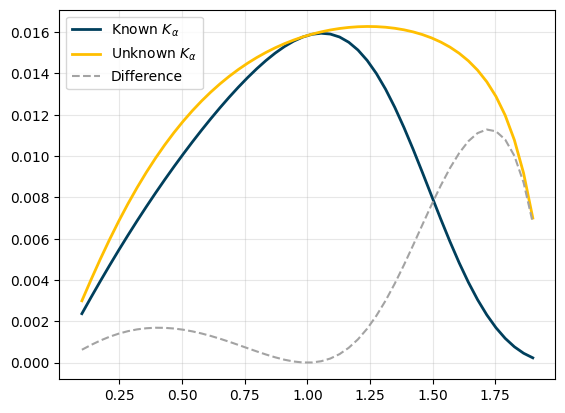

In [ ]:
# Example parameters
alphas = np.linspace(0.1, 1.9, 50) # anomalous exponent to check
T = 100  # Length of the trajectory
K_alpha = 1 # diffusion coefficient (note that these results are independnet of K_alpha)

# Variance with known K_alpha (i.e. inverse of diagonal term of the Fisher information matrix)
var_a_k = np.array([1/fisher_information_alpha(alpha, T) for alpha in alphas])

# Variance with unknown K_alpha (i.e. diagonal term of the inverse of the full Fisher information matrix)
var_a_uk = np.array([fisher_information_matrix(alpha, K_alpha, T)[1][0,0] for alpha in alphas])


plt.plot(alphas, var_a_k, c = '#003f5c', lw = 2, label = r'Known $K_\alpha$')
plt.plot(alphas, var_a_uk, c = '#ffbf00', lw = 2, label = r'Unknown $K_\alpha$')
plt.plot(alphas, var_a_uk-var_a_k, c = '#a3a3a3', ls = '--', label = 'Difference')
plt.grid(alpha = 0.3)
plt.xlabel(r'$\alpha$')
plt.legend()

# Maximum likelihood estimator

## Diffusion coefficient

In [ ]:
import torch
from scipy import fftpack

def compute_periodogram_dst(displacements, deltaT = 1):
    ''' From above Eq. (10) of 10.1103/PhysRevE.89.022726 '''
    N = len(displacements)  
    dst = fftpack.dst(displacements)    
    periodogram = 2*dst**2 / ((N+1)*deltaT)
    return periodogram

def log_likelihood(phi, periodogram, delta_t, R, N):
    a_k = 1 - 2 * R * (1 - torch.cos(torch.pi * torch.arange(1, N+1) / (N + 1)))
    b_k = 1 - torch.cos(torch.pi * torch.arange(1, N+1) / (N + 1))
    
    F_k = a_k * torch.cos(phi)**2 + b_k * torch.sin(phi)**2
    lambda_phi = torch.mean(periodogram / F_k)
    log_likelihood_value = -0.5 * torch.sum((periodogram / (lambda_phi * F_k)) + torch.log(lambda_phi * F_k))
    return -log_likelihood_value  # Minimizing the negative log-likelihood

# Function to estimate D and sigma^2
def mle_diffusion_coefficient(traj, # Trajectory to be analyzed
                              delta_t = 1, # time lag
                              R = 0 # Motion blur noise
                             )-> tuple: # Diffusion coefficient and std of localization precision
    ''' 
    Calculate the diffusion coefficient via Maximum Likelihood Estimation (MLE)

    Based on: Vestergaard et al. http://dx.doi.org/10.1103/PhysRevE.89.022726
    '''  
    
    displacements = (traj[1:]-traj[:-1]).tolist()
    N = len(displacements)
    periodogram = torch.tensor(compute_periodogram_dst(displacements))
    
    # Initial guess for phi
    phi = torch.tensor([0.001], requires_grad=True)
    
    # Optimizer
    optimizer = torch.optim.Adam([phi], lr=0.1)

    # Optimization loop
    phis, losses = [], []
    for _ in range(1000):
        optimizer.zero_grad()
        loss = log_likelihood(phi, periodogram, delta_t, R, N)
        loss.backward()
        optimizer.step()
        phis.append(float(phi.item()))
        losses.append(float(loss))
    # plt.loglog(losses, 'o-')
    # plt.title(losses[-1])
    
    phi_hat = torch.tensor([phi.item()])
    
    # Estimate λ and from it D and σ^2
    a_k = 1 - 2 * R * (1 - torch.cos(torch.pi * torch.arange(1, N+1) / (N + 1)))
    b_k = 1 - torch.cos(torch.pi * torch.arange(1, N+1) / (N + 1))
    
    F_k_hat = a_k * torch.cos(phi_hat)**2 + b_k * torch.sin(phi_hat)**2
    lambda_hat = torch.mean(periodogram / F_k_hat)
    
    D_hat = lambda_hat / (2 * delta_t + 2 * R * delta_t)
    sigma_squared_hat = lambda_hat * (1 - 2 * R) / (2 * delta_t)

    # print(torch.mean(periodogram), alt_D_sig(lambda_hat, phi_hat, delta_t))
    
    return D_hat.item(), sigma_squared_hat.item()

array([189.42779894, 189.42779894])

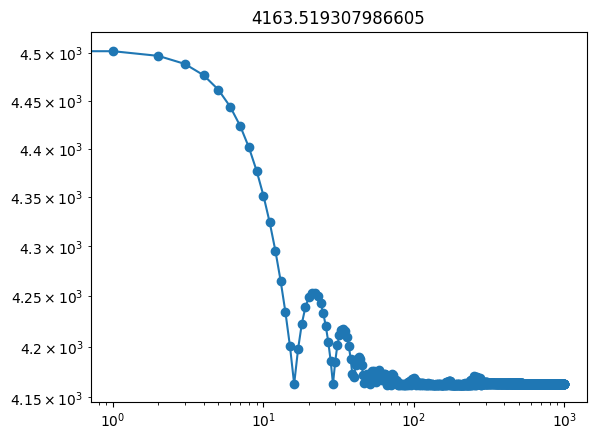

In [ ]:
traj = models_phenom().disp_fbm(D = 187, alpha = 1, T = 1000)

# traj += np.random.randn(len(traj))*0.1

np.array(mle_diffusion_coefficient(traj, R = 0.00))/8

In [ ]:
#eval: false
Ts = np.arange(10, 100, 10) # Trajectory lengths
# Ds = np.arange(0.5, 2.1, 0.5) # We will test on different diffusion coefficients

# Saving the standard deviations
std_ds = np.zeros(len(Ts))

D = 2.5
    
    # Generate the BM trajectories with given parameters
trajs = (np.sqrt(2*D)*np.random.randn(int(1e2), Ts[-1], 1)).cumsum(1) 

for idxL, T in enumerate(tqdm(Ts)):

    preds = []
    for traj in trajs:
        preds.append( mle_diffusion_coefficient(traj[:T], R = 0)[0])
    
    std_ds[idxL] = np.array(preds).std()

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
from andi_datasets.analysis import CRLB_D

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


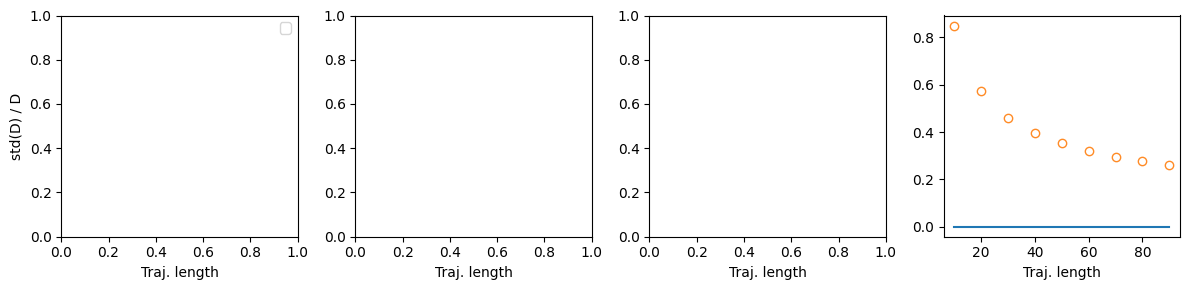

In [ ]:
fig, axs = plt.subplots(1,4, figsize = (4*3,3), tight_layout = True)

plt.plot(Ts, std_ds/D, label = r'MSD$_{1-2}$')
plt.scatter(Ts, CRLB_D(Ts), label = 'Cramer-Rao bound', alpha = 0.9, facecolor = 'w', edgecolor = 'C1')
axs[0].legend()
plt.setp(axs[0], ylabel = 'std(D) / D')
plt.setp(axs, xlabel = 'Traj. length');

In [ ]:
def alt_D_sig(lambda_, phi, delta_t = 1):
    
    tan_phi = np.tan(phi)
    
    # Calculate D
    D = lambda_ / (2 * delta_t**2 * (1 + tan_phi**2))
    
    # Calculate sigma
    sigma = np.sqrt(D * delta_t) * tan_phi
    
    return D.item(), sigma.item()
    

In [ ]:
#| hide
from andi_datasets.analysis import msd_analysis as MA
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from andi_datasets.models_phenom import models_phenom
from andi_datasets.utils_trajectories import bm1D

In [ ]:
np.tan(np.pi/2)

1.633123935319537e+16

In [ ]:
Ds_D = []
true_Ds = np.linspace(1,10,15)

for D in tqdm(true_Ds):
    
    Ds = []
    sigmas = []
    
    for _ in (range(30)):
        traj = models_phenom().disp_fbm(D = D, alpha = 1, T = 100)

        traj += np.random.randn(len(traj))
        
        D_hat, sigma_squared_hat = mle_diffusion_coefficient(traj, R = 1/6)
        Ds.append(D_hat)
        sigmas.append(sigma_squared_hat)

    Ds_D.append(Ds)

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
np.array(sigmas)-np.array(Ds)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
d_array = np.array(Ds_D)

[<matplotlib.lines.Line2D>]

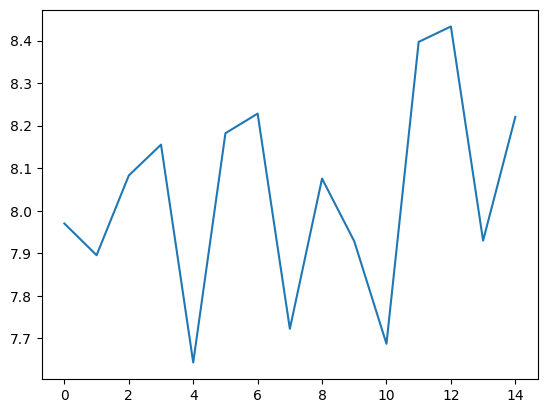

In [ ]:
plt.plot(d_array.mean(1)/true_Ds)

[<matplotlib.lines.Line2D>]

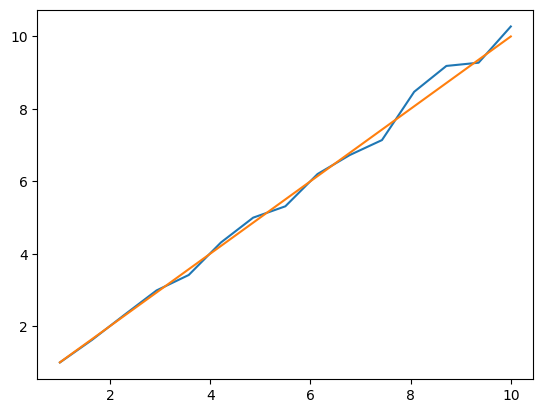

In [ ]:
plt.plot(true_Ds, d_array.mean(1)/8)
plt.plot(true_Ds, true_Ds)

<matplotlib.lines.Line2D>

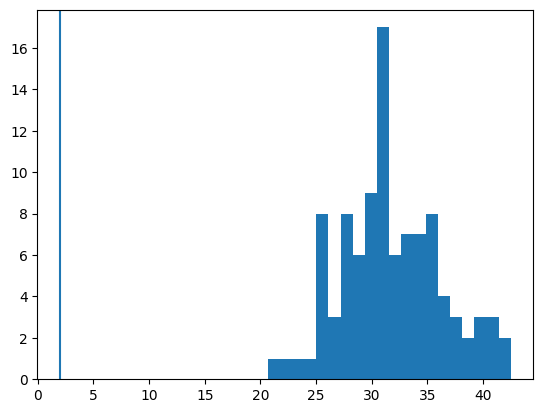

In [ ]:
plt.hist(Ds, bins = 20)
plt.axvline(2)

Runtime comparison with vanilla MSD:

In [ ]:
%timeit D_hat, sigma_squared_hat = mle_diffusion_coefficient(traj)

293 ms ± 503 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit MA().get_diff_coeff(traj)

108 µs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Anomalous exponent

In [ ]:
import numpy as np
from scipy.optimize import minimize

def calculate_msd(traj, delta_t):
    """Calculate mean squared displacement for different time lags from a trajectory."""
    n_points = len(traj)
    max_lag = n_points - 1
    msd = np.zeros(max_lag)
    for lag in range(1, max_lag + 1):
        displacements = traj[lag:] - traj[:-lag]
        msd[lag - 1] = np.mean(displacements**2)
    time_lags = delta_t * np.arange(1, max_lag + 1)
    return time_lags, msd

def msd_model(time_lags, alpha, D_alpha):
    """Calculate the model mean squared displacement for anomalous diffusion."""
    return D_alpha * time_lags ** alpha

def negative_log_likelihood(params, time_lags, displacements):
    """Calculate the negative log-likelihood for anomalous diffusion."""
    alpha, D_alpha = params
    
    # Calculate the expected MSD
    msd_model_values = msd_model(time_lags, alpha, D_alpha)
    
    # Add a small epsilon to avoid division by zero or log of zero
    epsilon = 1e-10
    msd_model_values = np.maximum(msd_model_values, epsilon)
    
    # Compute the negative log-likelihood
    nll = 0.5 * np.sum((displacements - msd_model_values) ** 2 / msd_model_values + np.log(msd_model_values))
    
    return nll

def mle_anomalous_exponent(traj, 
                           delta_t = 1):
    """Estimate the anomalous exponent alpha using MLE from a trajectory."""
    # Calculate time lags and mean squared displacements from the trajectory
    time_lags, displacements = calculate_msd(traj, delta_t)
    
    # Initial guess for alpha and D_alpha from a simple linear regression on log-log scale
    log_time_lags = np.log(time_lags)
    log_displacements = np.log(displacements)
    slope, intercept = np.polyfit(log_time_lags, log_displacements, 1)
    
    initial_alpha = slope
    initial_D_alpha = np.exp(intercept)
    
    initial_guess = [initial_alpha, initial_D_alpha]
    
    # Bounds for alpha (0, 2) and D_alpha (positive)
    bounds = [(0, 2), (0, None)]
    
    # Minimize the negative log-likelihood
    result = minimize(negative_log_likelihood, initial_guess, args=(time_lags, displacements), bounds=bounds, method='L-BFGS-B')
    
    # Extract the estimated parameters
    alpha_hat, D_alpha_hat = result.x
    
    return alpha_hat, D_alpha_hat


Estimated anomalous exponent (alpha): 0.7619363000702952
Estimated generalized diffusion coefficient (D_alpha): 2.059514404957091


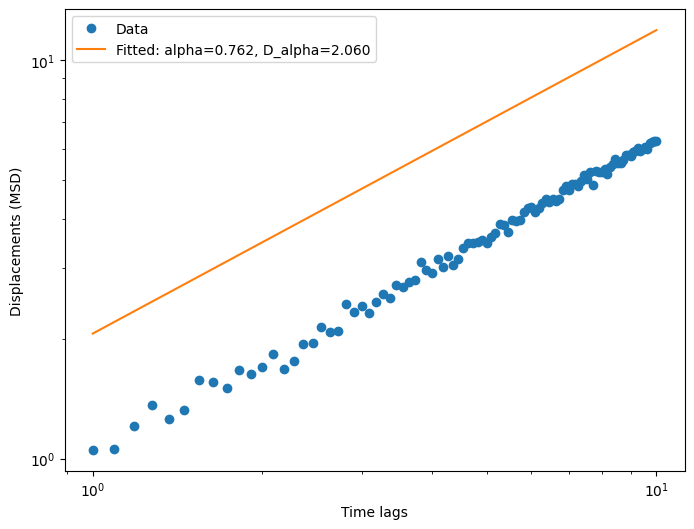

In [ ]:
# Example usage
np.random.seed(42)
T = 100
true_alpha = 0.8
D_alpha = 1.0

# Generate synthetic data with some noise
time_lags = np.linspace(1, 10, n_points)
displacements = msd(time_lags, true_alpha, D_alpha) + np.random.normal(0, 0.1, n_points)

traj = np.cumsum(models_phenom().disp_fbm(alpha = true_alpha, D = D_alpha, T = T))
# Estimate the anomalous exponent using MLE
alpha_hat, D_alpha_hat = mle_anomalous_exponent(traj)

print(f"Estimated anomalous exponent (alpha): {alpha_hat}")
print(f"Estimated generalized diffusion coefficient (D_alpha): {D_alpha_hat}")

# Plot the result
plt.figure(figsize=(8, 6))
plt.loglog(time_lags, displacements, 'o', label='Data')
plt.loglog(time_lags, msd(time_lags, alpha_hat, D_alpha_hat), '-', label=f'Fitted: alpha={alpha_hat:.3f}, D_alpha={D_alpha_hat:.3f}')
plt.xlabel('Time lags')
plt.ylabel('Displacements (MSD)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from scipy.optimize import minimize

def mle_diffusion_coefficient(displacements, time_lapse):
    """
    Computes the diffusion coefficient (D) using Maximum Likelihood Estimation (MLE).

    Parameters:
    displacements (np.array): Array of displacements (∆x) between successive time points.
    time_lapse (float): Time interval (Δt) between successive measurements.

    Returns:
    float: Estimated diffusion coefficient D.
    """

    # Define the log-likelihood function for the diffusion process
    def log_likelihood(params):
        D, sigma2 = params
        N = len(displacements)
        # Calculate lambda (λ) and phi (φ) based on the parameters D and σ²
        lam = (2 * D * time_lapse + 2 * sigma2) * time_lapse
        SNR = D / sigma2
        phi = np.pi / 2 - np.arctan(SNR)  # Replace arccot with the equivalent expression
        
        # Compute the periodogram terms
        Pk = np.abs(np.fft.fft(displacements))**2 / N
        Fk_phi = np.cos(phi)**2 + (1 - np.cos(2 * np.pi * np.arange(1, N+1) / (N+1))) * np.sin(phi)**2
        
        # Log-likelihood function
        logL = -0.5 * np.sum(np.log(lam * Fk_phi) + Pk / (lam * Fk_phi))
        
        return -logL

    # Initial guess for the parameters [D, σ²]
    initial_guess = [1e-12, 1e-6]

    # Minimize the negative log-likelihood to find the best parameters
    result = minimize(log_likelihood, initial_guess, bounds=[(0, None), (0, None)])

    # Extract the estimated diffusion coefficient D
    D_estimated = result.x[0]

    return D_estimated

In [ ]:
# Example usage
displacements = models_phenom().disp_fbm(alpha = 1, D = 2, T = 1000)
time_lapse = 0.01  # Replace with actual time lapse
D_estimated = mle_diffusion_coefficient(displacements, time_lapse)
print(f"Estimated Diffusion Coefficient: {D_estimated:.4e}")

Estimated Diffusion Coefficient: 3.8248e+03


In [ ]:
displacements = models_phenom().disp_fbm(alpha = 1, D = 2, T = 1000)

np.mean(displacements**2)/2

2.121571038632556

# p-variation

In [ ]:
#| export
def p_variation(traj, m, p):
    
    N = len(traj)
    sample_indexes = np.arange(0, N-m, m)
    pvar = np.zeros_like(traj)
    
    for t in range(N):
        sample_indexes_t = sample_indexes[sample_indexes < t]
        
        x_diff = np.abs(np.take(traj, sample_indexes_t+m) - np.take(traj, sample_indexes_t))
    
        pvar[t] = sum(x_diff ** p)
        
    return pvar
   

In [ ]:
#| export
from scipy.special import gamma

def p_variation_FBM(H : float, # Hurst exponent
                    sigma : float, # Standard deviation of the FBM process
                    t : np.array # times for which to compute p^(1/H) (t)
                   )-> np.array: # Theoretical prediction for the p^(1/H) (t)
    ''' 
    Given a Hurst exponent and the std of a FBM process with MSD = sigma^2 t^(2H), computes the predicted p-variation:
    
    p^(1/H) (t) = E(|B(1)|^(1/H))

    See more at Eq. (8) in https://doi.org/10.1103/PhysRevE.82.011129
    '''
    expected_value = sigma**(1/H) * 2**(1/(2*H)) / np.sqrt(np.pi) * gamma(1/(2*H) + 0.5) 
    pvar = t * expected_value
    return pvar

## Example 1: p-variation scaling for p = 2
In the case of `p = 2`, based on [[1]](http://dx.doi.org/10.1103/PhysRevLett.103.180602):

- For FBM: we should have an increasing p-variation with bigger resolution (in the paper it means increasing n in Eq.(5) but in the discrete version used here it means decreasing `m` (see Eq. (8) of [[2]](https://doi.org/10.1103/PhysRevE.82.021130)).
- For CTRW: the p-variation should estabilize to a value given [1] (i.e smaller `m` should start converging to this stable value).

In [ ]:
#| hide
from andi_datasets.models_theory import models_theory
import matplotlib.pyplot as plt

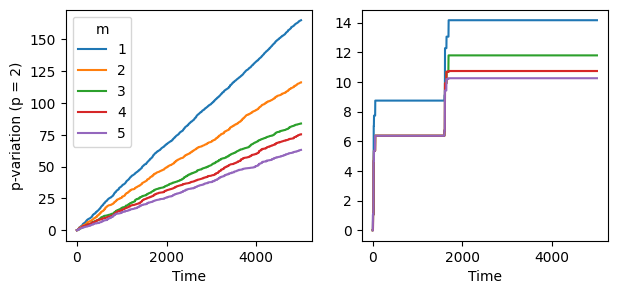

In [ ]:
T = 5000
H = 0.2

fbm_traj = models_theory().fbm(alpha = H*2, T = T)
ctrw_traj = models_theory().ctrw(alpha = H*2, T = T)

fig, ax = plt.subplots(1, 2, figsize = (7,3))

for m in [1,2,3,4,5]:
   
    pvar_fbm = p_variation(fbm_traj, p = 2, m = m)
    pvar_ctrw = p_variation(ctrw_traj, p = 2, m = m)

    ax[0].plot(np.arange(T), pvar_fbm, label = m)
    ax[1].plot(np.arange(T), pvar_ctrw, label = m)
    
ax[0].legend(title = 'm')
ax[0].set_ylabel('p-variation (p = 2)')
plt.setp(ax, xlabel = 'Time');

## Example 2: Theoretical estiation of p-variation for FBM and p = 1/H
In the case of `p = 1/H`, with `H` being the Hurst exponent, we can theoretically calculated the value of the p-variation for an FBM process (see Eq. (6) of [1]).

Text(0.5, 0, 'Time')

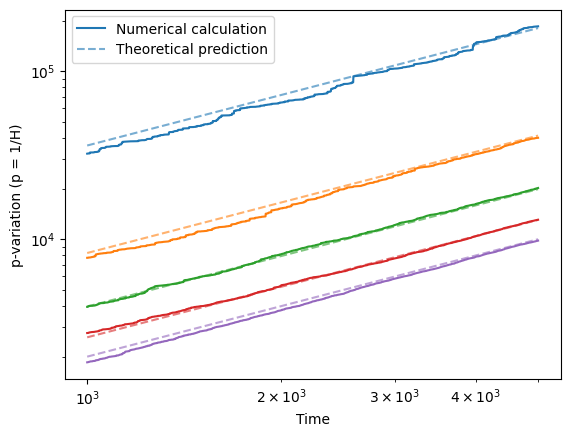

In [ ]:
T = 5000
pvar_alpha = []

Hs = np.linspace(0.2,0.5,5)
pvars = []
pvars_t = []
Ds_est = []

min_idx = 1000
for idxH, H in enumerate(Hs): 

    # We create a trajectory with fixed D = 1
    traj = np.cumsum(models_phenom().disp_fbm(D = 1, alpha = H*2, T = T))
    
    pvar = p_variation(traj, p = 1/H, m = 1)
    pvar_theory = p_variation_FBM(H = H, 
                                  sigma = np.sqrt(2), # Note that definition of diffusion coefficient is different 
                                                      # for models_phenom and this function, hence introducint a sqrt(2) factor
                                  t = np.arange(T))

    plt.loglog(np.arange(T)[min_idx:], pvar[min_idx:], label = 'Numerical calculation' if idxH == 0 else '')
    plt.plot(np.arange(T)[min_idx:], pvar_theory[min_idx:], label = 'Theoretical prediction' if idxH == 0 else '',
             c = f'C{idxH}', ls = '--', alpha = 0.6)
plt.legend()
plt.ylabel('p-variation (p = 1/H)')
plt.xlabel('Time')

# Power spectral density

In [ ]:
#| export
from scipy.signal import periodogram

def psd(traj : np.ndarray, # Trajectory of size (T,) (i.e. 1D) or (T, dim)
       )-> tuple: # (f, psd): frequencies f and power spectral density. Sizes f: (floor(T/2)), psd: (floor(T/2))
    
    ''' Calculates the approximate power spectral density based on scipy.periodogram'''

    # Checking dimensions of input trajectory
    if len(traj.shape) == 1:
        dim = 1
    else:
        dim = traj.shape[1]

    if dim == 1:
        return periodogram(traj)

    else:
        psd = []
        for t_dim in traj.transpose(1,0):
            f, psd_dim = periodogram(t_dim)
            psd.append(psd_dim)
        
        return f, np.array(psd).sum(0)
    

### Example: from clean to noisy trajectories

In [ ]:
T = int(1e5)
N = int(1e4)

Hs = np.array([1/3, 1, 3/2])/2

muH = np.zeros((len(Hs), int(T/2)))
stdH = np.zeros_like(muH)

muH_noise = np.zeros_like(muH)
stdH_noise = np.zeros_like(muH)

sigma_noise = 1e2

for idxH, H in enumerate(tqdm(Hs)):
    
    psdH = np.zeros((N, int(T/2)))
    psdH_noise = np.zeros((N, int(T/2)))
    
    for idxN in (range(N)):
        X = models_phenom().disp_fbm(D = 1, alpha = H*2, T = T).cumsum()
        f, psd = periodogram(X)
        psdH[idxN] = psd[1:]

        X_noise = X + np.random.randn(X.shape[0])*np.sqrt(sigma_noise)
        _, psd_noise = periodogram(X_noise)
        psdH_noise[idxN] = psd_noise[1:]

    
    muH[idxH] = psdH.mean(0)
    stdH[idxH] = psdH.std(0)

    muH_noise[idxH] = psdH_noise.mean(0)
    stdH_noise[idxH] = psdH_noise.std(0)

  0%|          | 0/3 [00:00<?, ?it/s]

<matplotlib.legend.Legend>

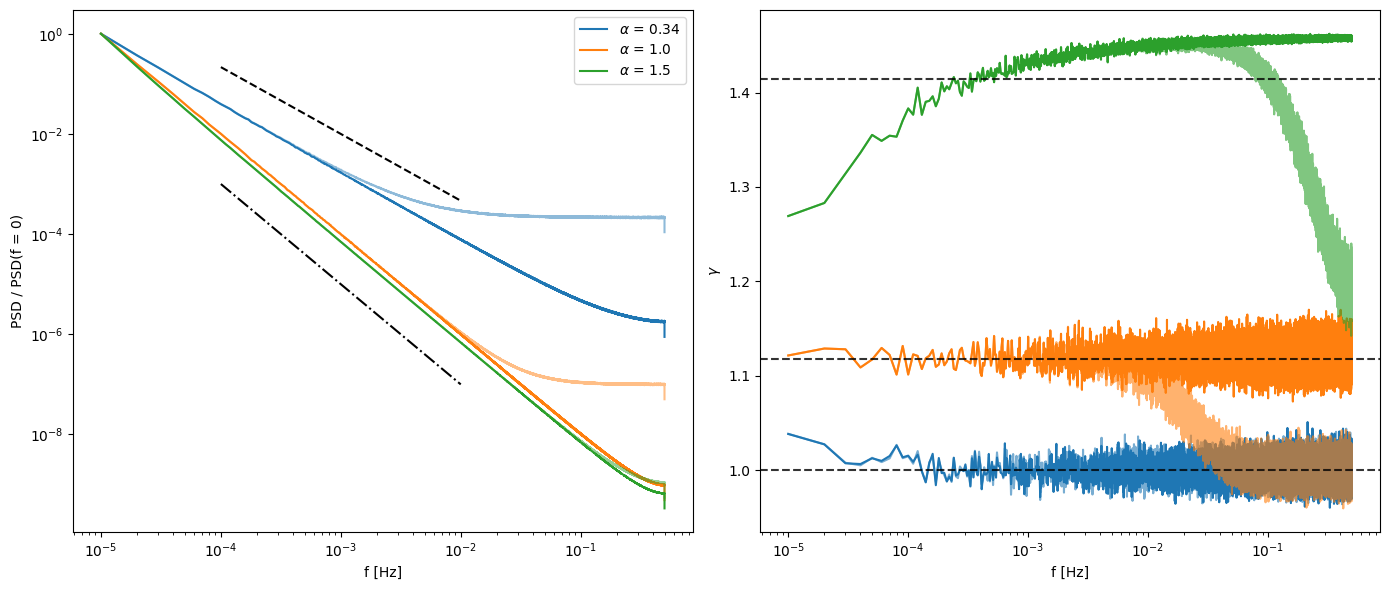

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14,6), tight_layout = True)

for idxH, H in enumerate((Hs)):
    ax[0].loglog(f[1:], muH[idxH]/muH[idxH,0], label = fr'$\alpha$ = {np.round(H,2)*2}')
    
    ax[0].loglog(f[1:], muH_noise[idxH]/muH_noise[idxH,0], c=f'C{idxH}', alpha = 0.5)
    if idxH == 0:
        ax[0].plot(np.linspace(1e-4, 1e-2, 10), 1e-6*np.linspace(1e-4, 1e-2, 10)**(-H*2-1), c = 'k', ls = '--')#, label = r'$\sim f^{-0.34+1}$')
    elif idxH == 1:
        ax[0].plot(np.linspace(1e-4, 1e-2, 10), 1e-11*np.linspace(1e-4, 1e-2, 10)**(-H*2-1), c = 'k', ls = '-.')#, label = r'$\sim f^{-2}$')

    ax[1].semilogx(f[1:-1], stdH[idxH, :-1]/ muH[idxH, :-1])
    ax[1].semilogx(f[1:-1], stdH_noise[idxH, :-1]/ muH_noise[idxH, :-1], c=f'C{idxH}', alpha = 0.6)


for line in [1, np.sqrt(2), np.sqrt(5)/2]: ax[1].axhline(line, c='k', ls = '--', alpha = 0.8)

plt.setp(ax[0], 
         xlabel = 'f [Hz]',
         ylabel = 'PSD / PSD(f = 0)'
        )

plt.setp(ax[1], 
         xlabel = 'f [Hz]',
         ylabel = r'$\gamma$'
        )

ax[0].legend()

In [ ]:
np.logspace(-4,2,10)

array([1.00000000e-04, 4.64158883e-04, 2.15443469e-03, 1.00000000e-02,
       4.64158883e-02, 2.15443469e-01, 1.00000000e+00, 4.64158883e+00,
       2.15443469e+01, 1.00000000e+02])

In [ ]:
ps = []
for _ in tqdm(range(1000)):
    noise = np.random.randn(1000)
    f, p = periodogram(noise)
    ps.append(p)

  0%|          | 0/1000 [00:00<?, ?it/s]

[<matplotlib.lines.Line2D>]

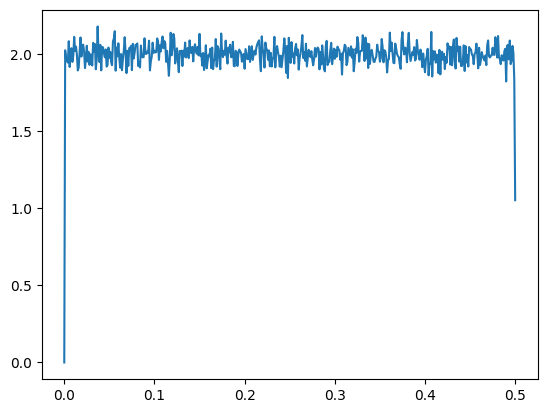

In [ ]:
plt.plot(f,np.array(ps).mean(0))

In [ ]:
T = int(1e2)
N = int(1e3)

H = 1/3

noises = np.logspace(-4,2,10)

muN = np.zeros((len(noises), int(T/2)))
stdN = np.zeros_like(muN)

for idxH, noise in enumerate(tqdm(noises)):
    
    psdH_noise = np.zeros((N, int(T/2)))
        
    for idxN in (range(N)):
        X_noise = models_phenom().disp_fbm(D = 1, alpha = H*2, T = T).cumsum()
        X_noise += np.random.randn(X_noise.shape[0])*np.sqrt(noise)
        f, psd_noise = periodogram(X_noise)
        psdH_noise[idxN] = psd_noise[1:]
        
    muN[idxH] = psdH_noise.mean(0)
    stdN[idxH] = psdH_noise.std(0)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
f, psd_noise = periodogram(X_noise)

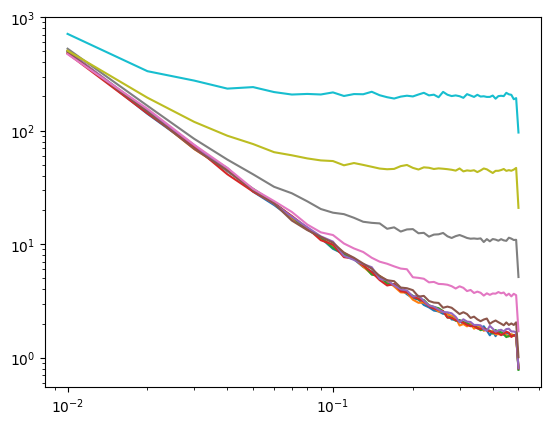

In [ ]:
for mu in muN:
    plt.loglog(f[1:], mu)

#| hide
# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()